In [61]:
import json
import math
import base64
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from celluloid import Camera
from IPython.display import Image
from IPython.display import HTML

BAYES_QUARTILE_OPT = 0.25
RATES = [1,2,3,4,5]
index = 0
asinToIndex = {}
scoreMatrix = []
booksAsin = []
colorsList = ["red", "orange", "green"]
colors = ListedColormap(colorsList)
chunks = pd.read_json(
    '../Dataset/Books.json', lines=True, chunksize=500000, 
    typ="frame", orient="records", dtype={"asin": str, "overall": int, "unixReviewTime": int}
)

nbChunks = 10 # <= 0 to load all chunks, positive integer to load specific number of chunks
for chunk in chunks:
    for _, item in chunk.iterrows():
        asin = item["asin"]
        rate = item["overall"]

        if (asin not in asinToIndex):
            scoreMatrix.append([0,0,0,0,0])
            booksAsin.append(asin)
            asinToIndex[asin] = index
            index += 1

        row = asinToIndex[asin]
        scoreMatrix[row][rate-1] += 1
    nbChunks -= 1
    if (nbChunks == 0):
        break

def getMedian(scoreMatrix, nbRating):
    def rowMedian(i):
        s = 0
        for k in sorted([0,1,2,3,4]):
            s += scoreMatrix[i,k]
            if s > nbRating[i] / 2:
                break
        return k + 1
    medianMat = np.array([ rowMedian(i) for i in range(0, nbRating.size) ])
    return medianMat

def getBookStats(scoreMatrix):
    nbRating = np.sum(scoreMatrix, axis=1)
    avgRatings = (np.average(scoreMatrix, axis=1, weights=RATES) * np.sum(RATES)) / nbRating
    medianMat = getMedian(scoreMatrix, nbRating)
    stdRatings = np.std(scoreMatrix, axis=1)
    confidenceNumber = np.quantile(nbRating, BAYES_QUARTILE_OPT)
    arithAverage = np.mean(avgRatings)
    bayesAvgRatings = (nbRating * avgRatings + arithAverage * confidenceNumber) / (nbRating + confidenceNumber)
    nbNonAppreciate = scoreMatrix[:,0]+scoreMatrix[:,1]
    nbNeutral = scoreMatrix[:,2]
    nbAppreciate = scoreMatrix[:,3]+scoreMatrix[:,4]
    return pd.DataFrame(
        data=np.column_stack((nbRating, avgRatings, bayesAvgRatings, medianMat, stdRatings, nbNonAppreciate, nbNeutral, nbAppreciate)),
        index=booksAsin, 
        columns=["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations"]
    )


scoreMatrix = np.array(scoreMatrix)
pdScoreMat = pd.DataFrame(
    data=scoreMatrix,
    index=booksAsin,
    columns=[f"{i} ⭐" for i in RATES]
)
display(pdScoreMat)

pdBooksFeatures = getBookStats(scoreMatrix)
display(pdBooksFeatures)

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐
000100039X,6,4,8,15,173
0001055178,0,4,2,10,2
0001473123,1,0,0,2,13
0001473727,0,0,0,0,7
0001473905,0,0,1,0,5
...,...,...,...,...,...
1402240902,0,0,1,7,1
1402240929,1,3,9,19,20
140224102X,4,3,3,7,42
1402241038,1,1,4,16,33


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations
000100039X,206.0,4.674757,4.660264,5.0,66.004242,10.0,8.0,188.0
0001055178,18.0,3.555556,3.745451,4.0,3.440930,4.0,2.0,12.0
0001473123,16.0,4.625000,4.505925,5.0,4.955805,1.0,0.0,15.0
0001473727,7.0,5.000000,4.616878,5.0,2.800000,0.0,0.0,7.0
0001473905,6.0,4.666667,4.433560,5.0,1.939072,0.0,1.0,5.0
...,...,...,...,...,...,...,...,...
1402240902,9.0,4.000000,4.102268,4.0,2.638181,0.0,1.0,8.0
1402240929,52.0,4.038462,4.061632,4.0,7.889233,4.0,9.0,39.0
140224102X,59.0,4.355932,4.342974,5.0,15.171025,7.0,3.0,49.0
1402241038,55.0,4.436364,4.413488,5.0,12.312595,2.0,4.0,49.0


In [62]:
booksFeatures = pdBooksFeatures.to_numpy()
NB_CLUSTERS = 3
CLASSES = [f"C{i+1}" for i in range(0, NB_CLUSTERS)]

# K means (Euclidean)
kmeansEucli = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(booksFeatures)
print("K-means Euclidean:")
display(pd.DataFrame(
    data=np.array([ [f"C{i+1}" for i in kmeansEucli.labels_] ]),
    index=["Class"],
    columns=booksAsin
))
display(pd.DataFrame(
    data=np.array([[np.count_nonzero(kmeansEucli.labels_ == i) for i in range(0, NB_CLUSTERS)]]),
    index=["Number of Classes"],
    columns=CLASSES
))

# K-means (Cosine similiarity)
kmeansCos = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(preprocessing.normalize(booksFeatures))
print("K-means Cosine similiarity:")
display(pd.DataFrame(
    data=np.array([ [f"C{i+1}" for i in kmeansCos.labels_] ]),
    index=["Class"],
    columns=booksAsin
))
display(pd.DataFrame(
    data=np.array([[np.count_nonzero(kmeansCos.labels_ == i) for i in range(0, NB_CLUSTERS)]]),
    index=["Number of Classes"],
    columns=CLASSES
))

K-means Euclidean:


,000100039X,0001055178,0001473123,0001473727,0001473905,0001712772,000171287X,0001714538,0002005395,0002006715,...,1402240589,140224066X,1402240686,1402240740,1402240856,1402240902,1402240929,140224102X,1402241038,1402241062
Class,C3,C1,C1,C1,C1,C1,C1,C1,C1,C1,...,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1


,C1,C2,C3
Number of Classes,181984,160,3563


K-means Cosine similiarity:


,000100039X,0001055178,0001473123,0001473727,0001473905,0001712772,000171287X,0001714538,0002005395,0002006715,...,1402240589,140224066X,1402240686,1402240740,1402240856,1402240902,1402240929,140224102X,1402241038,1402241062
Class,C1,C1,C2,C3,C3,C2,C2,C3,C2,C3,...,C2,C1,C1,C3,C2,C2,C1,C1,C1,C3


,C1,C2,C3
Number of Classes,59301,57071,69335


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations
000100039X,2.254714,0.862687,1.384512,0.678323,3.599570,0.689396,0.520460,2.602780
0001055178,-0.112362,-1.326692,-1.557958,-0.875760,-0.128222,0.142031,-0.106977,-0.147814
0001473123,-0.137544,0.765352,0.888086,0.678323,-0.037959,-0.131652,-0.316122,-0.100929
0001473727,-0.250861,1.498926,1.244960,0.678323,-0.166411,-0.222879,-0.316122,-0.225956
0001473905,-0.263452,0.846860,0.655325,0.678323,-0.217709,-0.222879,-0.211549,-0.257212
...,...,...,...,...,...,...,...,...
1402240902,-0.225680,-0.457271,-0.410268,-0.875760,-0.176053,-0.222879,-0.211549,-0.210327
1402240929,0.315726,-0.382033,-0.540972,-0.875760,0.136828,0.142031,0.625032,0.274152
140224102X,0.403862,0.239003,0.363957,0.678323,0.570708,0.415714,-0.002404,0.430436
1402241038,0.353499,0.396342,0.590765,0.678323,0.400391,-0.040424,0.102169,0.430436


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Nb rating,0.480599,0.075651,-0.113482,-0.012601,0.000498,0.002528,-0.394892,7.709205e-01
Average Rating,-0.061789,0.575342,0.127389,0.399286,-0.030635,-0.698722,-0.018840,1.165734e-15
Bayes Rating,-0.067710,0.576868,-0.004973,0.400580,0.059184,0.705827,0.021346,-1.246399e-15
Median,-0.049109,0.537642,0.207492,-0.811659,-0.077518,0.024194,0.009560,-3.220080e-17
STD,0.439592,0.138409,-0.444209,-0.072996,0.317035,-0.080147,0.691388,-1.246225e-14
Depreciation,0.383966,-0.090672,0.746907,0.059518,0.519094,0.038094,0.026572,-1.063992e-01
Neutral,0.450256,-0.031745,0.276480,0.102894,-0.786591,0.070257,0.277411,-9.282090e-02
Appreciations,0.463475,0.114179,-0.310134,-0.041215,0.029247,-0.013888,-0.536170,-6.210838e-01


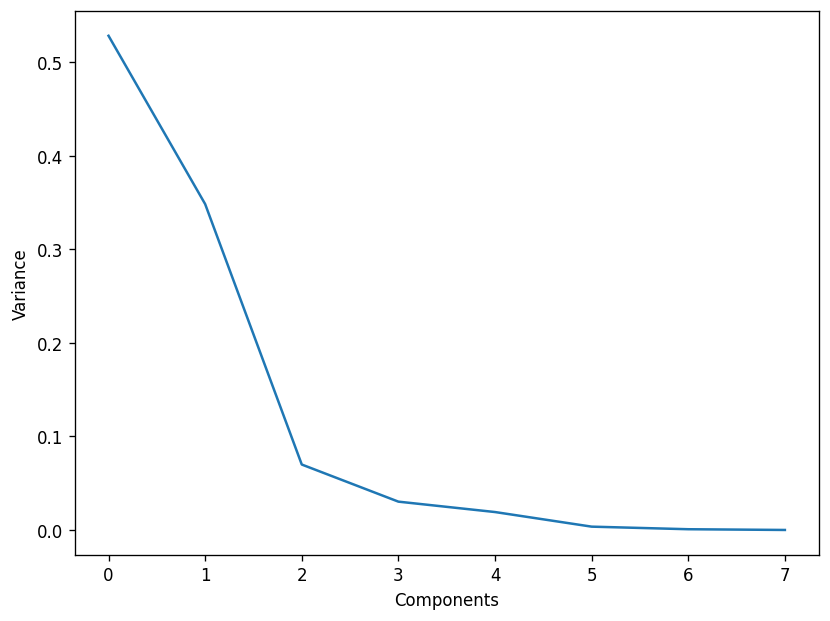

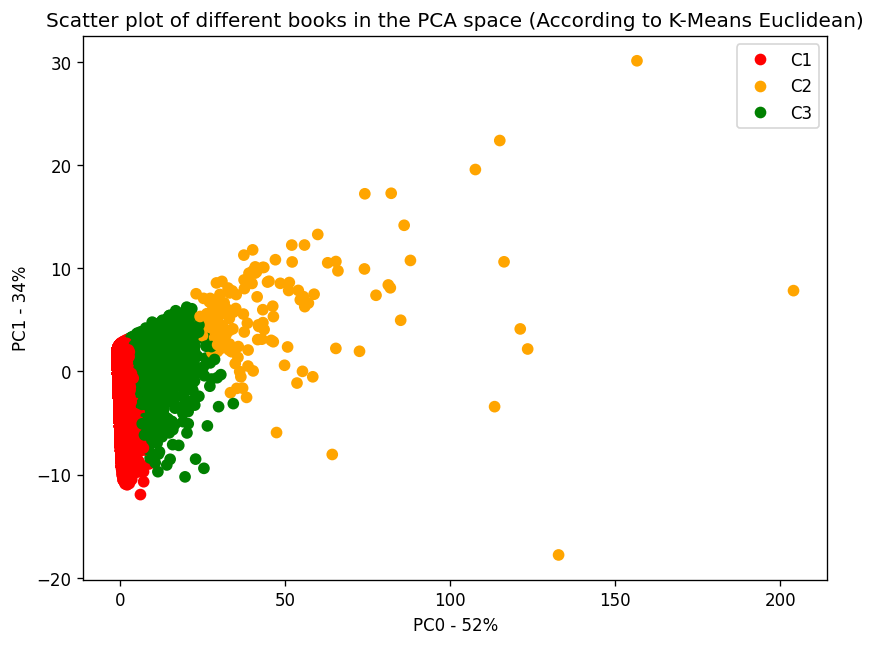

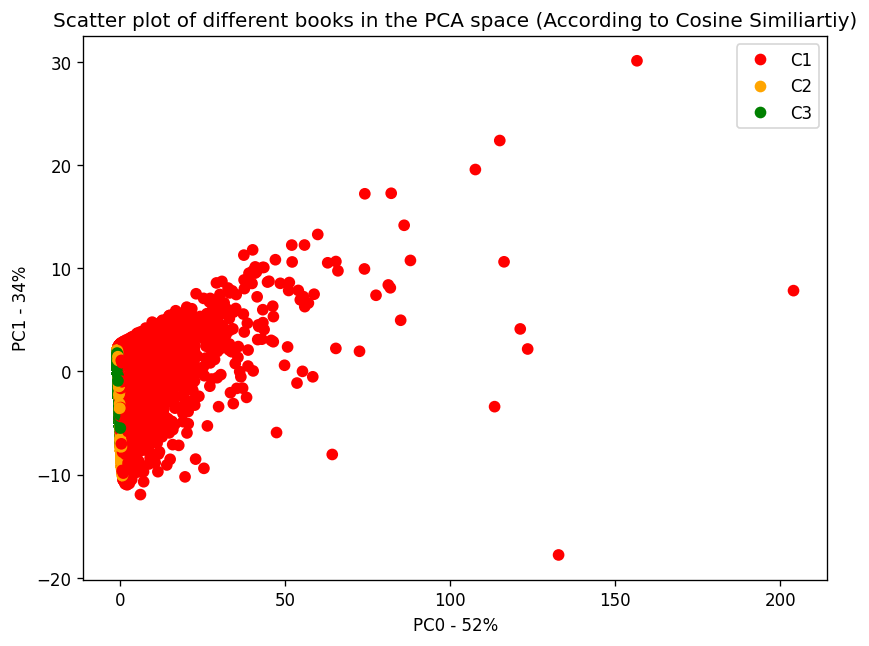

In [63]:
# Data Normalization
pdBooksFeaturesNormalized = (pdBooksFeatures - pdBooksFeatures.mean()) / pdBooksFeatures.std()
display(pdBooksFeaturesNormalized)

# PCA Calculations
pca = PCA(n_components=pdBooksFeatures.shape[1])
pca.fit(pdBooksFeaturesNormalized)

# PCA Results
booksFeaturesPCA = pd.DataFrame(
    data=pca.components_.T,
    columns=[f"PC{i}" for i in range(len(pdBooksFeaturesNormalized.columns))],
    index=pdBooksFeatures.columns
)

display(booksFeaturesPCA)
plt.figure(figsize=(8, 6), dpi=120)
plt.plot(pca.explained_variance_ratio_)
plt.ylabel("Variance")
plt.xlabel("Components")
plt.show()

# Plot PCA (2 major axis)
booksFeatures2PCA = pd.DataFrame(
    data=pca.transform(pdBooksFeaturesNormalized), 
    columns=[f"PC{i}" for i in range(len(pdBooksFeaturesNormalized.columns))]
)

def plotPCA(dataToPlot, dataLabels, titleExtra=""):
    plt.figure(figsize=(8, 6), dpi=120)
    plt.xlabel(f"PC0 - {math.floor(pca.explained_variance_ratio_[0]*100)}%")
    plt.ylabel(f"PC1 - {math.floor(pca.explained_variance_ratio_[1]*100)}%")
    scatter = plt.scatter(x=dataToPlot["PC0"], y=dataToPlot["PC1"], c=dataLabels, cmap=colors)
    plt.legend(handles=scatter.legend_elements(num=3)[0], labels=CLASSES)
    plt.title(f"Scatter plot of different books in the PCA space ({titleExtra})")
    plt.show()

plotPCA(booksFeatures2PCA, kmeansEucli.labels_, "According to K-Means Euclidean")
plotPCA(booksFeatures2PCA, kmeansCos.labels_, "According to Cosine Similiartiy")